*************************************************************
Tutorial to Calibrate the *betrack* Command `track-particles`
=================================
*************************************************************

This tutorial will guide you during the calibration of the 
particle tracker underlying the `track-particles` command. For
more information, you can refer to the official *betrack* 
[documentation](http://soft-matter.github.io/trackpy/) and 
also to the documentation of the module 
[`trackpy`](http://soft-matter.github.io/trackpy/). 


1 Loading and Preprocessing a Video
---------------------------------

The first step to calibrate the particle tracking engine is to
select a video file that properly represents the family of 
videos/experiments you want to work with. This video will be used
during calibration and the resulting configuration should apply
similarly to other videos taken under the same condtions. You can also 
select a particular frame among those of your video to work on 
(default: `selectedFrame = 0`).

Adjust the path below to select a video file and, if you want, change
the default setting for the `selectedFrame`:

In [76]:
fileName      = '/Users/gabrielevalentini/Dropbox (ASU)/TandemRuns/data/videos/TR-T1-002.mp4'
selectedFrame = 1000

We can now create a tracking job and use it, for example, to show the selected frame of the video. Note that the interactive view of Jupyter lets you zoom in and out in the selected frame. This feature will be of help later on. 

Video file: /Users/gabrielevalentini/Dropbox (ASU)/TandemRuns/data/videos/TR-T1-002.mp4
Output directory: /Users/gabrielevalentini/Dropbox (ASU)/TandemRuns/data/videos


<IPython.core.display.Javascript object>


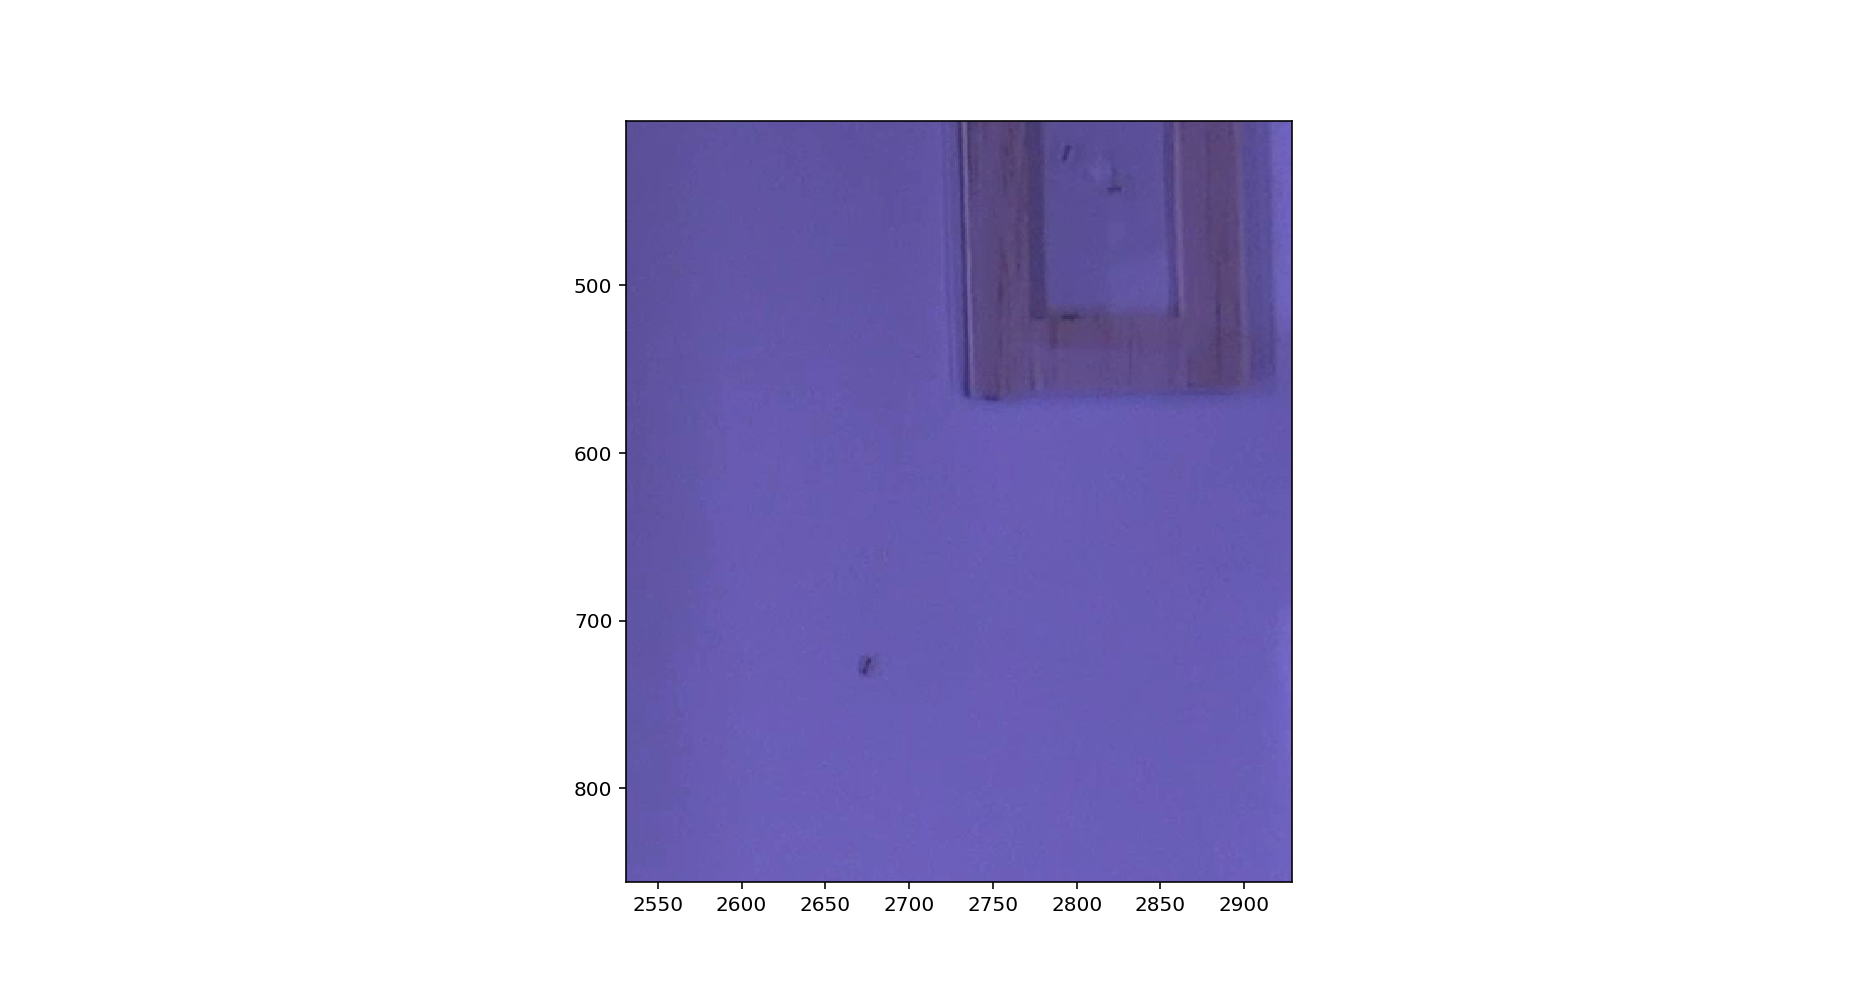

In [90]:
from __future__ import division, unicode_literals, print_function

import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import HTML
from os.path import isfile
from betrack.utils.job import Job
from betrack.utils.message import *

if isfile(fileName):
    calibJob = Job(fileName)
    mprint(calibJob.str())
    calibJob.load_frames()
    
    %matplotlib notebook
    mpl.rc('figure', figsize=(13,7))    
    mpl.rc('image', cmap='gray')
    
    plt.imshow(calibJob.frames[selectedFrame])
else:
    eprint('File not found:', fileName)
    

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')

Before looking for features in the frames of your videos, *betrack* preprocesses each video. If necessary, *betrack* converts your videos to grayscale and, if properly instructed, it can crop the videos and invert their colors. 

Cropping a video to eliminate portions that are not of interest for the tracker can considerably improve tracking performance. To crop the video set `cropMargins = [<xmin>, <xmax>, <ymin>, <ymax>]`; you can use the interactive visualization above to decide the values of the new margins. if you don't want to crop the video set `cropMargins = None`.

Inverting the colors of the video is instead a step necessary when your features in the video are darker than the background of the video. This because, by default, the tracking engine used in *betrack* looks for bright features.
To invert the colors set `invertColors = True ` otherwise set `invertColors = False` to disable this feature. 

Adjust the variables below to crop and/or invert the colors of the video selected above:

In [78]:
cropMargins  = [1350, 2800, 400, 1400]
invertColors = True

<IPython.core.display.Javascript object>


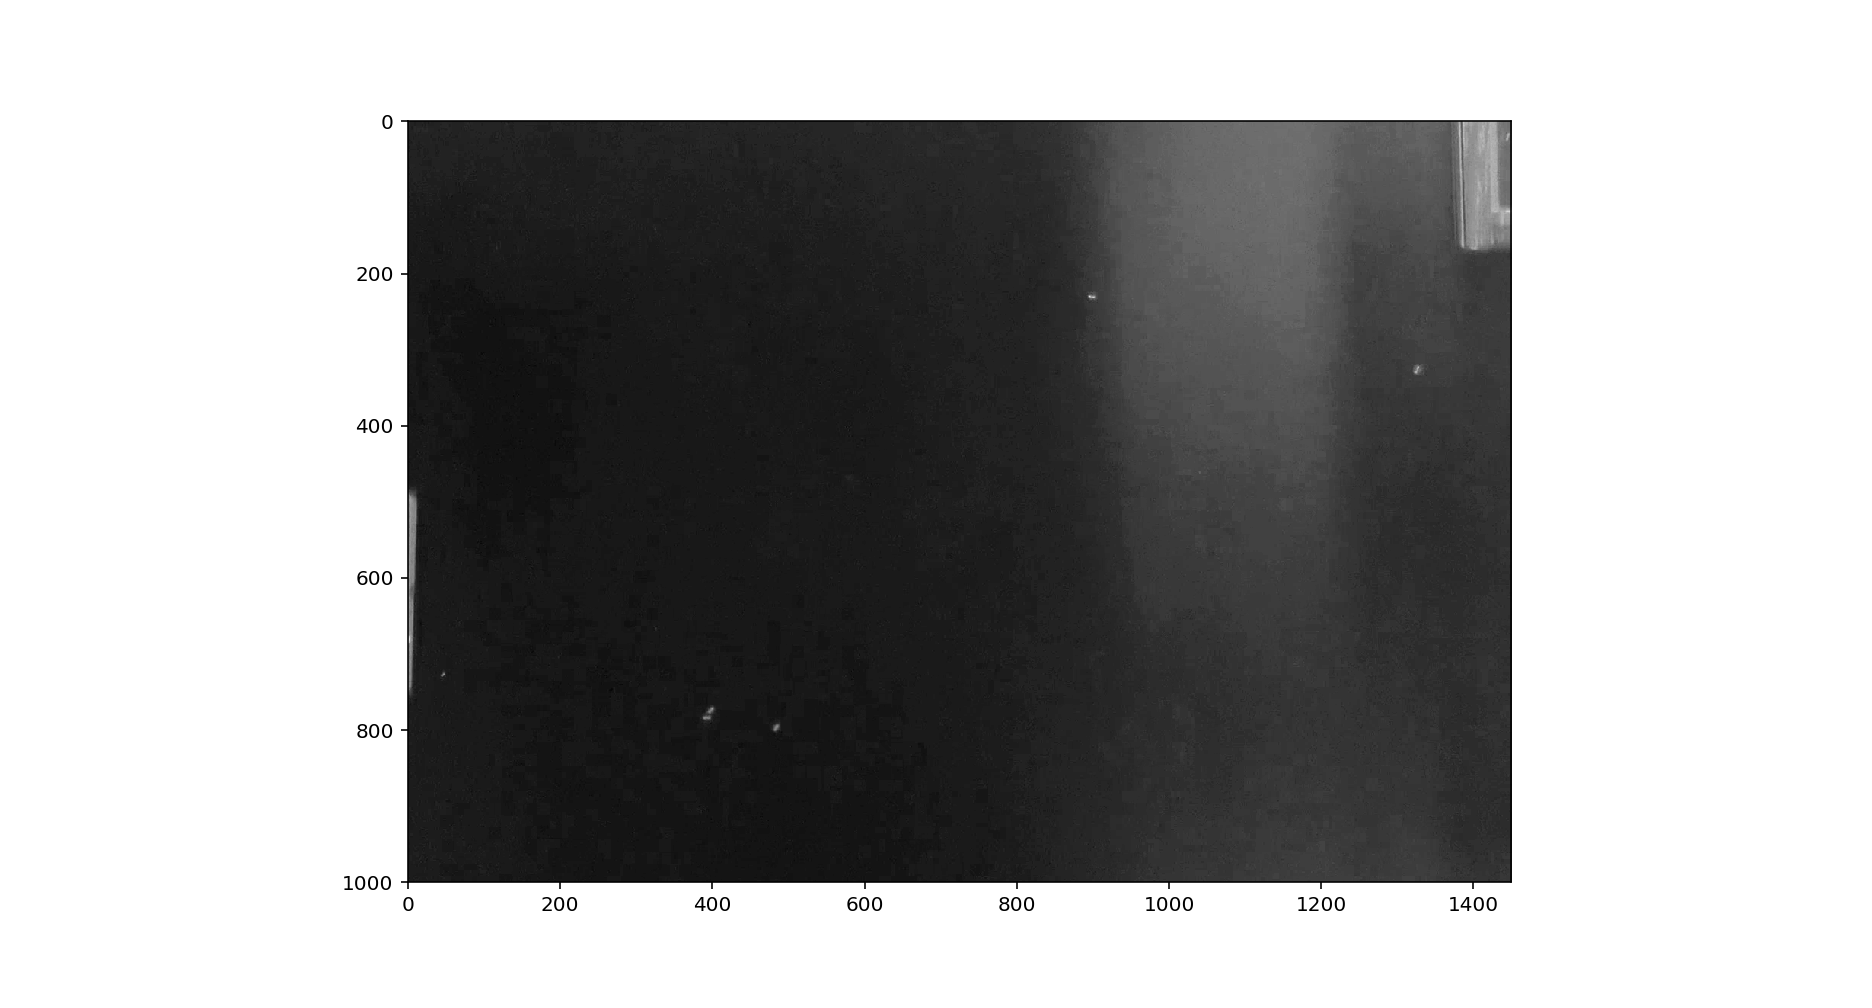

In [91]:
if cropMargins is not None: 
    calibJob.margins = cropMargins

calibJob.preprocess_video(invert=invertColors)

plt.figure()
plt.imshow(calibJob.pframes[selectedFrame])

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')

The image above gives you an idea of how the tracking engine of *betrack* sees your video. More preprocessing of the input videos is usually performed by *betrack* in the background. 


2 Locate Features
----------------

Bla bla bla.. loop back and forth between section to refine parameters..

### 2.1 Particle Diameter

To properly locate features in each frame, the tracking engine used by *betrack* requires to know the size in pixels, in terms of diameter, of the features to be tracked. This parameter is particularly important: too small values lead to many features being untracked; too big values increase computational complexity and reduce accuracy. In general, however, is better to choose a marginally bigger value than a smaller one as the diameter is also subject to the contraints of being an odd, integer number.

Adjust the variable below to properly set the diameter of features:

In [235]:
locateDiameter = 9

...Locating features: 100%|██████████| 1/1 [00:00<00:00,  2.19 frame/s, nfeatures=38]


<IPython.core.display.Javascript object>


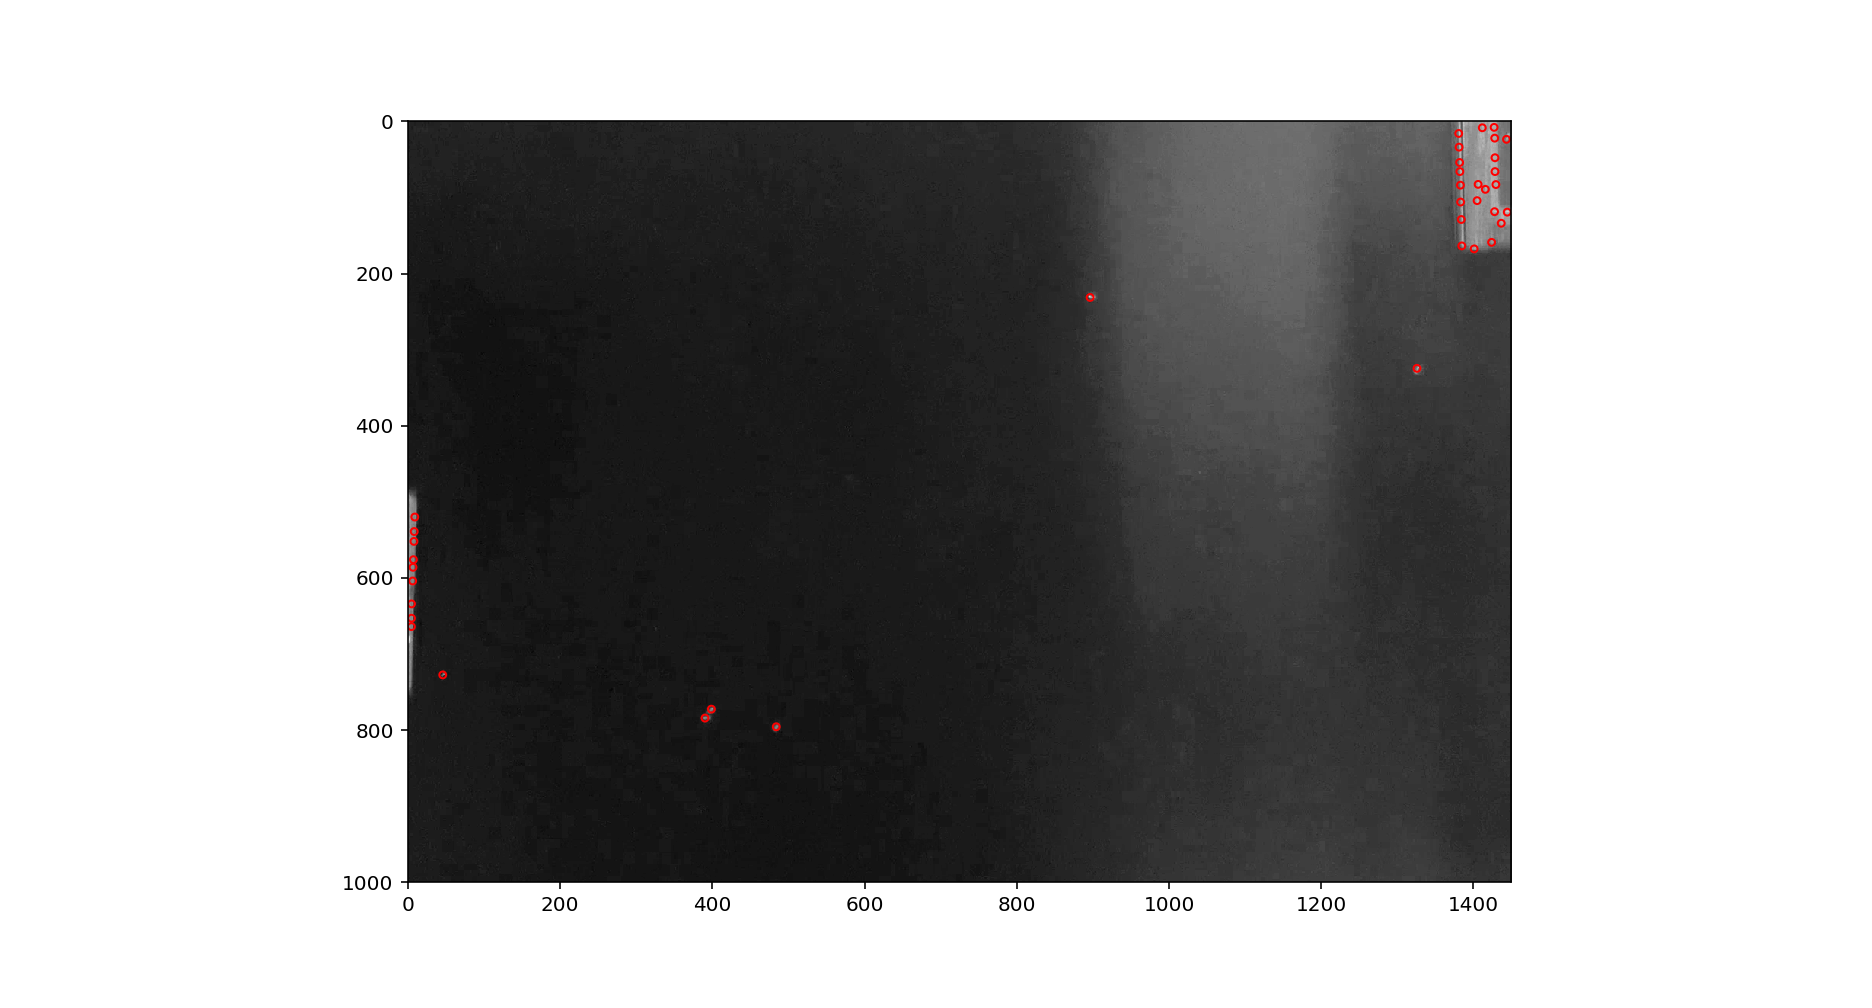

In [236]:
import trackpy
from matplotlib.collections import PatchCollection
from betrack.commands.trackparticles import TrackParticles

calibJob.period        = [selectedFrame, selectedFrame + 1]
cjOldNFrames           = calibJob.nframes
calibJob.nframes       = 1
opt                    = {'--configuration': 'noconf.yml'} # We'll bypass the YAML configuration file..
tp                     = TrackParticles(opt)
tp.locate_diameter     = locateDiameter
tp.locate_features(calibJob)

with trackpy.PandasHDFStoreBig(calibJob.h5storage) as sf:
    df = sf.dump()
df = df[df['frame'] == selectedFrame]

plt.figure()
plt.imshow(calibJob.pframes[selectedFrame])

ax = plt.gca()
for p in range(0, df.shape[0]):
    pos = [tuple(x) for x in df.iloc[[p]][['x','y']].values][0]
    cir = plt.Circle(pos, radius= tp.locate_diameter / 2,
                    edgecolor='r', facecolor='none')
    ax.add_artist(cir)

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')

Unless your video is particularly simple to track, you will have noticed in the image above that *betrack* finds a large number of false positives, that is, it wrongly recognizes features where there are any. As the current configuration of *betrack* is minimal (in effect, the minimal configuration necessary to run the `track-particles` command), this result is to be expected. We will improve upon this result in the next sections. For the moment, play around with the parameter `locateDiameter` and make sure that all or most of your features are correctly recognized, that is, try to reduce as much as possible the number of false negatives. 

### 2.2 Minimum mass and maximum size of features

A powerful parameter that allows to strongly reduce the number of false positive is the minimum mass of your features in terms of integrated brightness. That is, how bright your features are. *betrack* can select features based on this parameter and reduce the number of false positives.

Similarly, you can instruct *betrack* to cut off features based on their size in terms of maximum radius-of-gyration of their brightness. The default value for this parameter is `locateMaxSize = None`.

Start by adjusting the variable below to properly set the minimum mass of features (default value: `locateMinmass = 100`). After you have found a sufficiently good parameterization of the minimum mass, you can adjust the value of `locateMaxSize` (tip: start with a bigger values and iteratively reduce it).

In [233]:
locateMinmass = 400
locateMaxSize = 3

...Locating features: 100%|██████████| 1/1 [00:00<00:00,  1.90 frame/s, nfeatures=11]


<IPython.core.display.Javascript object>


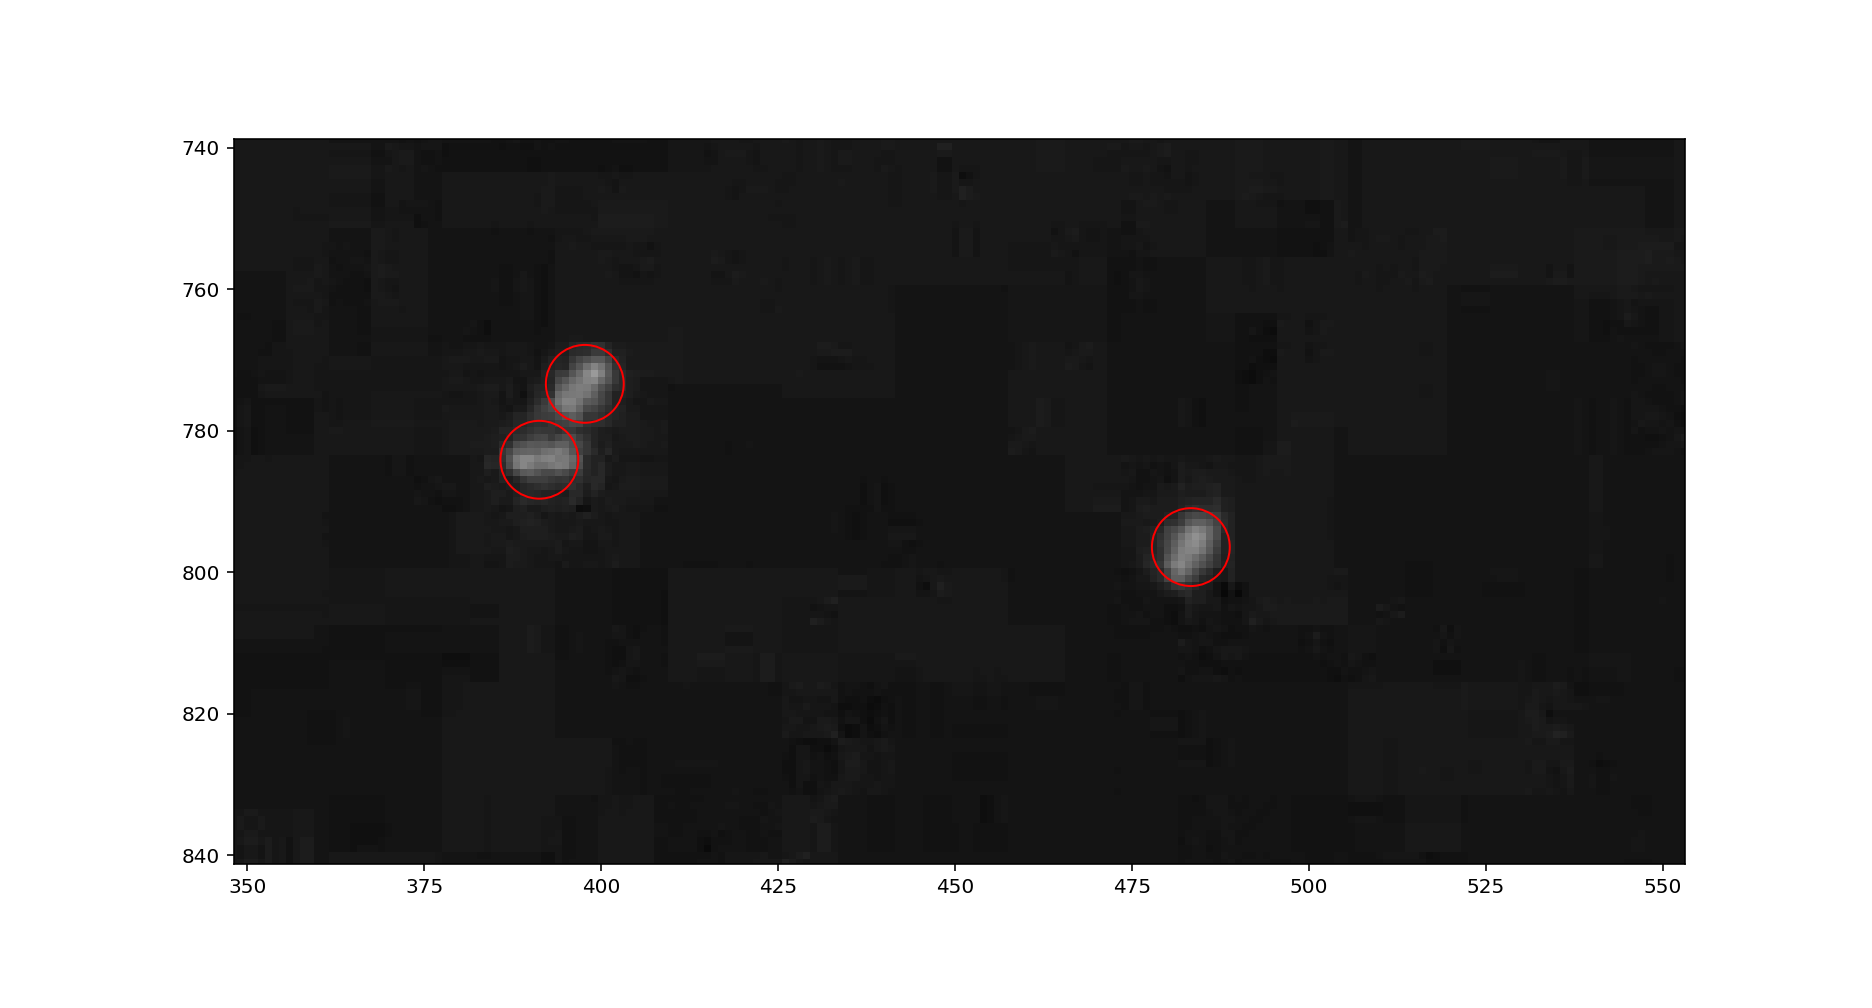

In [234]:
tp                     = TrackParticles(opt)
tp.locate_diameter     = locateDiameter
tp.locate_minmass      = locateMinmass
tp.locate_maxsize      = locateMaxSize
tp.locate_features(calibJob)

with trackpy.PandasHDFStoreBig(calibJob.h5storage) as sf:
    df = sf.dump()
df = df[df['frame'] == selectedFrame]

plt.figure()
plt.imshow(calibJob.pframes[selectedFrame])

ax = plt.gca()
for p in range(0, df.shape[0]):
    pos = [tuple(x) for x in df.iloc[[p]][['x','y']].values][0]
    cir = plt.Circle(pos, radius= tp.locate_diameter / 2,
                    edgecolor='r', facecolor='none')
    ax.add_artist(cir)

HTML('''<script>
code_show=true; 
function code_toggle() {
    if (code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>

To show/hide this cell's raw code input, click <a href="javascript:code_toggle()">here</a>.''')

### 2.3 Advanced calibration parameters

## 3 Linking particles

## 4 Filtering Trajectories

## 5 Exporting a Configuration File